In [1]:
from __future__ import division
from utils import *
from functions import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000 - PhD/figures/"+todayStr+"/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)



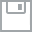
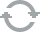
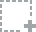
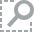
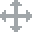
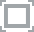
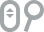
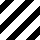
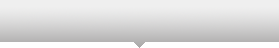
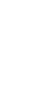
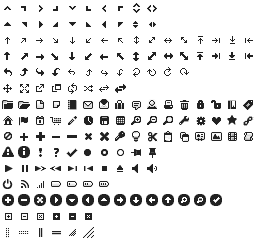
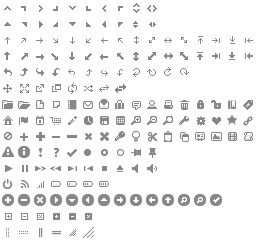
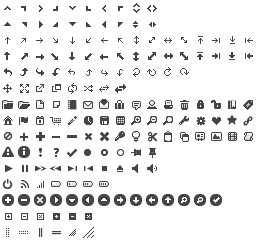
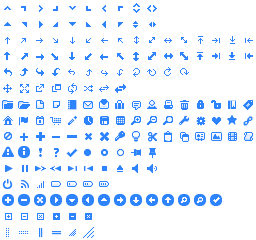
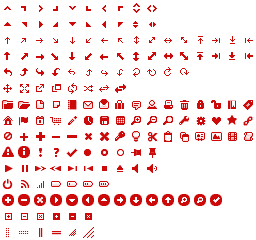
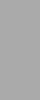
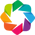
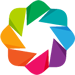

In [2]:
from bokeh.io import output_notebook
output_notebook()

In [3]:
# Instantiate classes
cortex = Cortex()
trn = TRN()
gr = GRAPH()

def xax(gamma, duration):
    x= np.arange(0,(duration-1)/1000,(duration)/1000/len(gamma) )
    return x

## PLASTICITY FUNCTION OF RATIO AND STIM 

In [ ]:
N = 10000
G = 4.8
d1 = 10000
d2 = 10000
d3 = 10000
before = d1+d2
after = d3
S = 100
sigma = 60
WII = 500
FACT = 1
ratio = 13
r=0.8
model = "gp-izh"
it = 8
binsize=1000
coeff=1
stimVals = range(0,200,20)
ratioRange = range(8,22,2)
# ratioRange=[7]
# stimVals = [80]
for FACT in [0.1,0.5,1]:
    for ratio in ratioRange:
        LTD  = 4.7e-6 * FACT * N
        LTP = ratio * LTD
        Parallel(n_jobs=8)(delayed(cortex.runSimulation)(N=N, r=r,G=G,S=S, d1=d1, d2=d2, d3=d3, \
                                                         before=before, after=after,s=sigma,
                               WII=WII, LTP=LTP, LTD=LTD, model=model) for S in stimVals)

    colors = plt.cm.Purples(np.linspace(0, 1, len(stimVals)*3))

    for ratio in ratioRange:
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(111)
        ax.set_ylim([0,5])
        LTD  = 4.7e-6 * FACT * N
        LTP = ratio * LTD
        for S, c in zip(stimVals, colors[int(len(colors)/3):]):
            spikes_x, spikes_y, spikes_x_tc, spikes_y_tc,\
            gamma, correlation, ssp1,\
            stimulation,p,q,lowsp,vm = cortex.readSimulation(N, r, 0, G, S, d1, d2, d3, \
                                                             before, after, WII, LTP, LTD, model, )
            titlestr = r'$N=%d$  $\frac{\alpha_{LTP}}{\alpha_{LTD}}=%d$  $g_0=%.1f$  $\nu=%d$' %(N, ratio, G, sigma)

            plt.plot(xax(gamma,d1+d2+d3), gamma, color=c)
            plt.title(titlestr)
            cycle = []
            for i,g in enumerate(gamma):
                if i<(len(gamma)-10)/3 or i>=2*len(gamma)/3:
                    cycle.append([g,0])
                else:
                    cycle.append([g,S])
            np.save(DIRECTORY + 'cycle-%d-%d-%d'%(S,ratio, FACT), cycle)
        plt.savefig(DIRECTORY+'all-gamma_%d-%d.pdf'%(ratio,FACT))

## CORRELATION + GAMMA + LFP

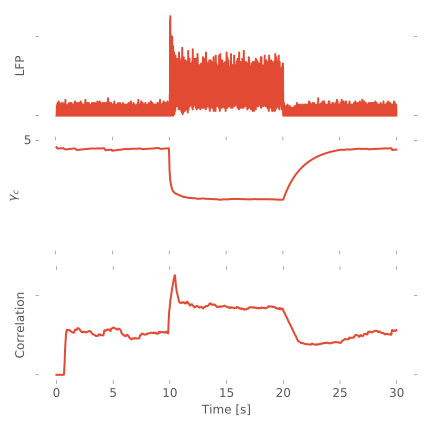

In [46]:
S = 80
spikes_x, spikes_y, spikes_x_tc, spikes_y_tc, gamma, correlation, ssp1, stimulation,p,q,lowsp,vm = cortex.readSimulation(N,r, 0, G, S, d1, d2, d3, before, after, WII, LTP, LTD, model)
_,_,_,_,ssp  = cortex.readPSTH(N,r, G,S, 1,binsize, d1, d2, d3, before, after, sigma, WII, LTP, LTD, model,coeff,RON='IAF', tau_m = 1)

ssp1 =ssp
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(312)
ax.set_xticklabels([])
ax.set_yticks([1,5])
ax.set_ylim([1.5,5])
ax.plot(xax(gamma,d1+d2+d3), gamma)
ax.set_ylabel(r'$\gamma_c$')
ax = fig.add_subplot(313)
ax.plot(xax(correlation,d1+d2+d3),correlation)
ax.set_yticklabels([])
ax.set_ylabel('Correlation')
ax.set_xlabel('Time [s]')
ax = fig.add_subplot(311)
# ax.plot(xax(ssp1,d1+d2+d3),ssp1)
ssp2 = ssp1
ax.plot(np.arange(0,len(ssp2)*2,2),ssp2)
ax.set_yticklabels([])
ax.set_ylabel('LFP')
ax.set_xticks([])
# ax.set_xlim([0,360000])
plt.tight_layout()
plt.savefig(DIRECTORY + 'gammaPTSH2_-S%d.png'%(S))

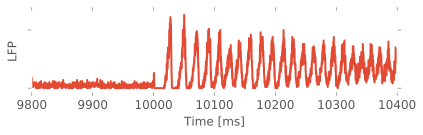

In [48]:
xlim = [9.8,10.4]
xlim2 = [xlim[0]*1000, xlim[1]*1000]
## GAMMA
fig = plt.figure(figsize=(6,2))


## LFP
ax = fig.add_subplot(111)
# ax.plot(xax(ssp1,d1+d2+d3),ssp1)
ax.plot(np.arange(0,len(ssp1)/4,0.25),ssp1)
ax.set_yticklabels([])
ax.set_ylabel('LFP')
# ax.set_xticks([])
ax.set_xlim(xlim2)
ax.set_xlabel('Time [ms]')
plt.tight_layout()
plt.savefig(DIRECTORY + 'gammaPTSH_lim_-S%d.pdf'%(S))

In [20]:
def findIndex2(spikes_x,val):
    res = (spikes_x-val).argmin()
    return res

findIndex2(spikes_x,20500)

183464

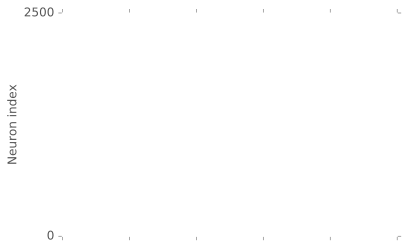

In [41]:
xlim2 = [9800,10400]
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
x1 = findIndex2(spikes_x,int(xlim2[0]))
x2 = findIndex2(spikes_x,int(xlim2[1]))
# ax.scatter(spikes_x[x1:x2], spikes_y[x1:x2], marker='.', color='k')
ax.set_yticks([0,2500])
ax.set_ylabel('Neuron index')
ax.set_xticklabels([])
plt.savefig(DIRECTORY+'rasterplot.pdf')

In [96]:
findIndex2(spikes_x,int(xlim2[0]))

144025

In [42]:
start =800000
gr.plotRasterGPU(spikes_x[x1:x2],spikes_y[x1:x2], "")


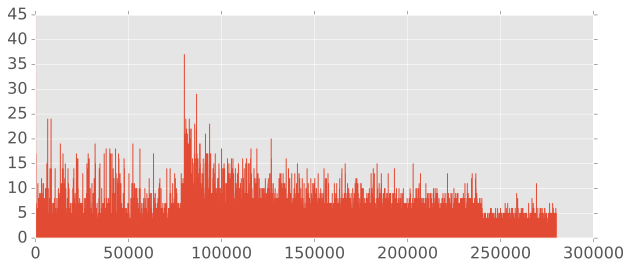

In [56]:
plt.plot(ssp1)

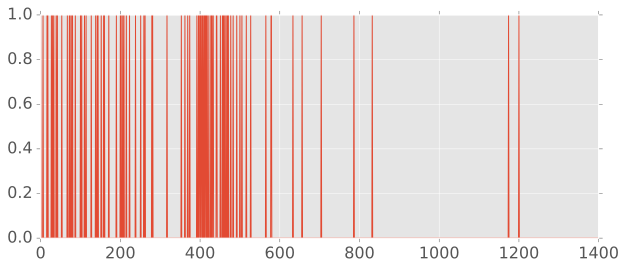

In [59]:
plt.plot(cortex.getHist((gr.readoutSpikes(ssp1,100)),200))

## SPECTROGRAM

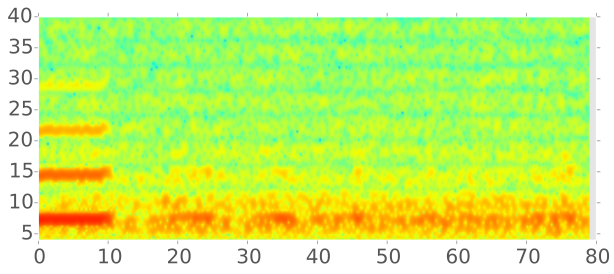

In [200]:
dt = 0.00025


# x = [np.sin(2*i) + np.sin(i) + 5*np.random.rand()+np.sin(3*i) for i in np.arange(0,40000)]
NFFT = 6000      # the length of the windowing segments
Fs = 1/dt  # the sampling frequency

# ax1 = plt.subplot(211)
# plt.plot(t, x)
ax = plt.subplot(111)
ax.grid(False)
Pxx, freqs, bins, im = plt.specgram(movingaverage(ssp1[:],1000), NFFT=NFFT, Fs=Fs, noverlap = 5000, pad_to=12000,
                             detrend='none'   )
ax.set_ylim([4,40])
plt.show()